In [21]:
import gc
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 200)

### description

- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

- imbalance_size - The amount unmatched at the current reference price (in USD).

- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
    - buy-side imbalance; 1
    - sell-side imbalance; -1
    - no imbalance; 0

- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

- matched_size - The amount that can be matched at the current reference price (in USD).

- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.

- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.

- wap - The weighted average price in the non-auction book.
$$
\frac{BidPrice * AskSize + AskPrice * BidSize}{BidSize + AskSize}
$$

- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
Where t is the time at the current observation, we can define the target:
$$
Target = \left(\frac{StockWAP_{t+60}}{StockWAP_t} - \frac{IndexWAP_{t+60}}{IndexWAP_t}\right) * 10000
$$

All size related columns are in USD terms.

All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

sample_submission A valid sample submission, delivered by the API. See this notebook for a very simple example of how to use the sample submission.

revealed_targets When the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.

public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

example_test_files/ Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.

optiver2023/ Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

In [22]:
input_dir_path = pathlib.Path('../inputs')

### load train dataset

In [23]:
def preprocess(df_):
    df_.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df_.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df_.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df_.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df_.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df_.eval('diff_far_near_price = far_price - near_price', inplace=True)
    df_.eval('sum_far_near_price = far_price + near_price', inplace=True)
    df_.eval('diff_ref_bid_price = reference_price - bid_price', inplace=True)
    df_.eval('diff_ref_ask_price = reference_price - ask_price', inplace=True)
    df_['wap_lag6'] = df_.groupby(['stock_id', 'date_id'])['wap'].shift(6)
    df_.eval('wap_lag6_div_wap = wap_lag6 / wap', inplace=True)
    df_.eval('seconds_in_bucket = seconds_in_bucket / 540', inplace=True)
    df_.eval('diff_ask_matched_size = ask_size - matched_size', inplace=True)
    df_.eval('diff_bid_matched_size = bid_size - matched_size', inplace=True)
    df_.eval('diff_ask_reference_price = ask_price - reference_price', inplace=True)
    df_.eval('diff_bid_reference_price = bid_price - reference_price', inplace=True)
    df_.eval('feature37 = (ask_price - bid_price) * ((ask_size - bid_size) / (ask_size + bid_size))', inplace=True)
    df_.eval('feature38 = ((ask_size - bid_size) / (ask_size + bid_size))', inplace=True)

In [24]:
train_df = pd.read_csv(input_dir_path.joinpath('train.csv'))
table = pd.pivot_table(data=train_df, index=['date_id'], columns=['seconds_in_bucket'], values=['stock_id'], aggfunc='count')
display(table)
display(table.iloc[280:300])

table = pd.pivot_table(data=train_df, index=['date_id', 'seconds_in_bucket'], columns=['stock_id'], values=['wap'], aggfunc='count')
display(table.head(20))

# train_df['imbalance_size'] /= 1e+06
# train_df['matched_size'] /= 1e+06
# train_df['ask_size'] /= 1e+06
# train_df['bid_size'] /= 1e+06

preprocess(train_df)

stock_id                                                    \
seconds_in_bucket      0    10   20   30   40   50   60   70   80   90   100   
date_id                                                                        
0                      191  191  191  191  191  191  191  191  191  191  191   
1                      191  191  191  191  191  191  191  191  191  191  191   
2                      191  191  191  191  191  191  191  191  191  191  191   
3                      191  191  191  191  191  191  191  191  191  191  191   
4                      192  192  192  192  192  192  192  192  192  192  192   
...                    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
476                    200  200  200  200  200  200  200  200  200  200  200   
477                    200  200  200  200  200  200  200  200  200  200  200   
478                    200  200  200  200  200  200  200  200  200  200  200   
479                    200  200  200  200  200  200  200  200  200  200  200   
480                    200  200  200  200  200  200  200  200  200  200  200   

                                                                               \
seconds_in_bucket  110  120  130  140  150  160  170  180  190  200  210  220   
date_id                                                                         
0                  191  191  191  191  191  191  191  191  191  191  191  191   
1                  191  191  191  191  191  191  191  191  191  191  191  191   
2                  191  191  191  191  191  191  191  191  191  191  191  191   
3                  191  191  191  191  191  191  191  191  191  191  191  191   
4                  192  192  192  192  192  192  192  192  192  192  192  192   
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
476                200  200  200  200  200  200  200  200  200  200  200  200   
477                200  200  200  200  200  200  200  200  200  200  200  200   
478                200  200  200  200  200  200  200  200  200  200  200  200   
479                200  200  200  200  200  200  200  200  200  200  200  200   
480                200  200  200  200  200  200  200  200  200  200  200  200   

                                                                               \
seconds_in_bucket  230  240  250  260  270  280  290  300  310  320  330  340   
date_id                                                                         
0                  191  191  191  191  191  191  191  191  191  191  191  191   
1                  191  191  191  191  191  191  191  191  191  191  191  191   
2                  191  191  191  191  191  191  191  191  191  191  191  191   
3                  191  191  191  191  191  191  191  191  191  191  191  191   
4                  192  192  192  192  192  192  192  192  192  192  192  192   
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
476                200  200  200  200  200  200  200  200  200  200  200  200   
477                200  200  200  200  200  200  200  200  200  200  200  200   
478                200  200  200  200  200  200  200  200  200  200  200  200   
479                200  200  200  200  200  200  200  200  200  200  200  200   
480                200  200  200  200  200  200  200  200  200  200  200  200   

                                                                               \
seconds_in_bucket  350  360  370  380  390  400  410  420  430  440  450  460   
date_id                                                                         
0                  191  191  191  191  191  191  191  191  191  191  191  191   
1                  191  191  191  191  191  191  191  191  191  191  191  191   
2                  191  191  191  191  191  191  191  191  191  191  191  191   
3                  191  191  191  191  191  191  191  191  191  191  191  191   
4                  192  192  192  192  192  192  192  192  1

stock_id                                                    \
seconds_in_bucket      0    10   20   30   40   50   60   70   80   90   100   
date_id                                                                        
280                    199  199  199  199  199  199  199  199  199  199  199   
281                    199  199  199  199  199  199  199  199  199  199  199   
282                    199  199  199  199  199  199  199  199  199  199  199   
283                    199  199  199  199  199  199  199  199  199  199  199   
284                    199  199  199  199  199  199  199  199  199  199  199   
285                    199  199  199  199  199  199  199  199  199  199  199   
286                    199  199  199  199  199  199  199  199  199  199  199   
287                    199  199  199  199  199  199  199  199  199  199  199   
288                    199  199  199  199  199  199  199  199  199  199  199   
289                    199  199  199  199  199  199  199  199  199  199  199   
290                    199  199  199  199  199  199  199  199  199  199  199   
291                    199  199  199  199  199  199  199  199  199  199  199   
292                    199  199  199  199  199  199  199  199  199  199  199   
293                    199  199  199  199  199  199  199  199  199  199  199   
294                    199  199  199  199  199  199  199  199  199  199  199   
295                    200  200  200  200  200  200  200  200  200  200  200   
296                    200  200  200  200  200  200  200  200  200  200  200   
297                    200  200  200  200  200  200  200  200  200  200  200   
298                    200  200  200  200  200  200  200  200  200  200  200   
299                    200  200  200  200  200  200  200  200  200  200  200   

                                                                               \
seconds_in_bucket  110  120  130  140  150  160  170  180  190  200  210  220   
date_id                                                                         
280                199  199  199  199  199  199  199  199  199  199  199  199   
281                199  199  199  199  199  199  199  199  199  199  199  199   
282                199  199  199  199  199  199  199  199  199  199  199  199   
283                199  199  199  199  199  199  199  199  199  199  199  199   
284                199  199  199  199  199  199  199  199  199  199  199  199   
285                199  199  199  199  199  199  199  199  199  199  199  199   
286                199  199  199  199  199  199  199  199  199  199  199  199   
287                199  199  199  199  199  199  199  199  199  199  199  199   
288                199  199  199  199  199  199  199  199  199  199  199  199   
289                199  199  199  199  199  199  199  199  199  199  199  199   
290                199  199  199  199  199  199  199  199  199  199  199  199   
291                199  199  199  199  199  199  199  199  199  199  199  199   
292                199  199  199  199  199  199  199  199  199  199  199  199   
293                199  199  199  199  199  199  199  199  199  199  199  199   
294                199  199  199  199  199  199  199  199  199  199  199  199   
295                200  200  200  200  200  200  200  200  200  200  200  200   
296                200  200  200  200  200  200  200  200  200  200  200  200   
297                200  200  200  200  200  200  200  200  200  200  200  200   
298                200  200  200  200  200  200  200  200  200  200  200  200   
299                200  200  200  200  200  200  200  200  200  200  200  200   

                                                                               \
seconds_in_bucket  230  240  250  260  270  280  290  300  310  320  330  340   
date_id                                                                         
280                199  199  199  199  199  199  199  199  199  199  1

wap                                               \
stock_id                   0    1    2    3    4    5    6    7    8    9     
date_id seconds_in_bucket                                                     
0       0                  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        10                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        20                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        30                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        40                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        50                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        60                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        70                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        80                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        90                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        100                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        110                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        120                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        130                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        140                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        150                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        160                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        170                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        180                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        190                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

                                                                             \
stock_id                   10   11   12   13   14   15   16   17   18   19    
date_id seconds_in_bucket                                                     
0       0                  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        10                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        20                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        30                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        40                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        50                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        60                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        70                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        80                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        90                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        100                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        110                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        120                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        130                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        140                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        150                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        160                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        170                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        180                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        190                1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

                                                                             \
stock_id                   20   21   22   23   24   25   26   27   28   29    
date_id seconds_in_bucket                                                     
0       0                  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
        10                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [25]:
display(train_df.isna().sum())
display(train_df.loc[train_df['target'].isna()])

stock_id                          0
date_id                           0
seconds_in_bucket                 0
imbalance_size                  220
imbalance_buy_sell_flag           0
reference_price                 220
matched_size                    220
far_price                   2894342
near_price                  2857180
bid_price                       220
bid_size                          0
ask_price                       220
ask_size                          0
wap                             220
target                           88
time_id                           0
row_id                            0
diff_ask_bid_price              220
sum_ask_bid_price               220
diff_ask_bid_size                 0
sum_ask_bid_size                  0
diff_far_near_price         2894342
sum_far_near_price          2894342
diff_ref_bid_price              220
diff_ref_ask_price              220
wap_lag6                     571612
wap_lag6_div_wap             571612
diff_ask_matched_size       

stock_id  date_id  seconds_in_bucket  imbalance_size  \
369508        131       35           0.000000             NaN   
369700        131       35           0.018519             NaN   
369892        131       35           0.037037             NaN   
370084        131       35           0.055556             NaN   
370276        131       35           0.074074             NaN   
...           ...      ...                ...             ...   
4225338       158      388           0.944444             NaN   
4225538       158      388           0.962963             NaN   
4225738       158      388           0.981481             NaN   
4225938       158      388           1.000000             NaN   
4764999        19      438           0.000000             NaN   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
369508                         1              NaN           NaN        NaN   
369700                         1              NaN           NaN        NaN   
369892                         1              NaN           NaN        NaN   
370084                         1              NaN           NaN        NaN   
370276                         1              NaN           NaN        NaN   
...                          ...              ...           ...        ...   
4225338                        1              NaN           NaN        NaN   
4225538                        1              NaN           NaN        NaN   
4225738                        1              NaN           NaN        NaN   
4225938                        1              NaN           NaN        NaN   
4764999                        0              NaN           NaN        NaN   

         near_price  bid_price  bid_size  ask_price  ask_size  wap  target  \
369508          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
369700          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
369892          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
370084          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
370276          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
...             ...        ...       ...        ...       ...  ...     ...   
4225338         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4225538         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4225738         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4225938         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4764999         NaN        NaN       0.0        NaN       0.0  NaN     NaN   

         time_id       row_id  diff_ask_bid_price  sum_ask_bid_price  \
369508      1925     35_0_131                 NaN                NaN   
369700      1926    35_10_131                 NaN                NaN   
369892      1927    35_20_131                 NaN                NaN   
370084      1928    35_30_131                 NaN                NaN   
370276      1929    35_40_131                 NaN                NaN   
...          ...          ...                 ...                ...   
4225338    21391  388_510_158                 NaN                NaN   
4225538    21392  388_520_158                 NaN                NaN   
4225738    21393  388_530_158                 NaN                NaN   
4225938    21394  388_540_158                 NaN                NaN   
4764999    24090     438_0_19                 NaN                NaN   

         diff_ask_bid_size  sum_ask_bid_size  diff_far_near_price  \
369508                 0.0               0.0                  NaN   
369700                 0.0               0.0                  NaN   
369892                 0.0               0.0                  NaN   
370084                 0.0               0.0                  NaN   
370276                 0.0               0.0                  NaN   
...                    ...               ...                  ...   
422533

<Axes: xlabel='stock_id'>

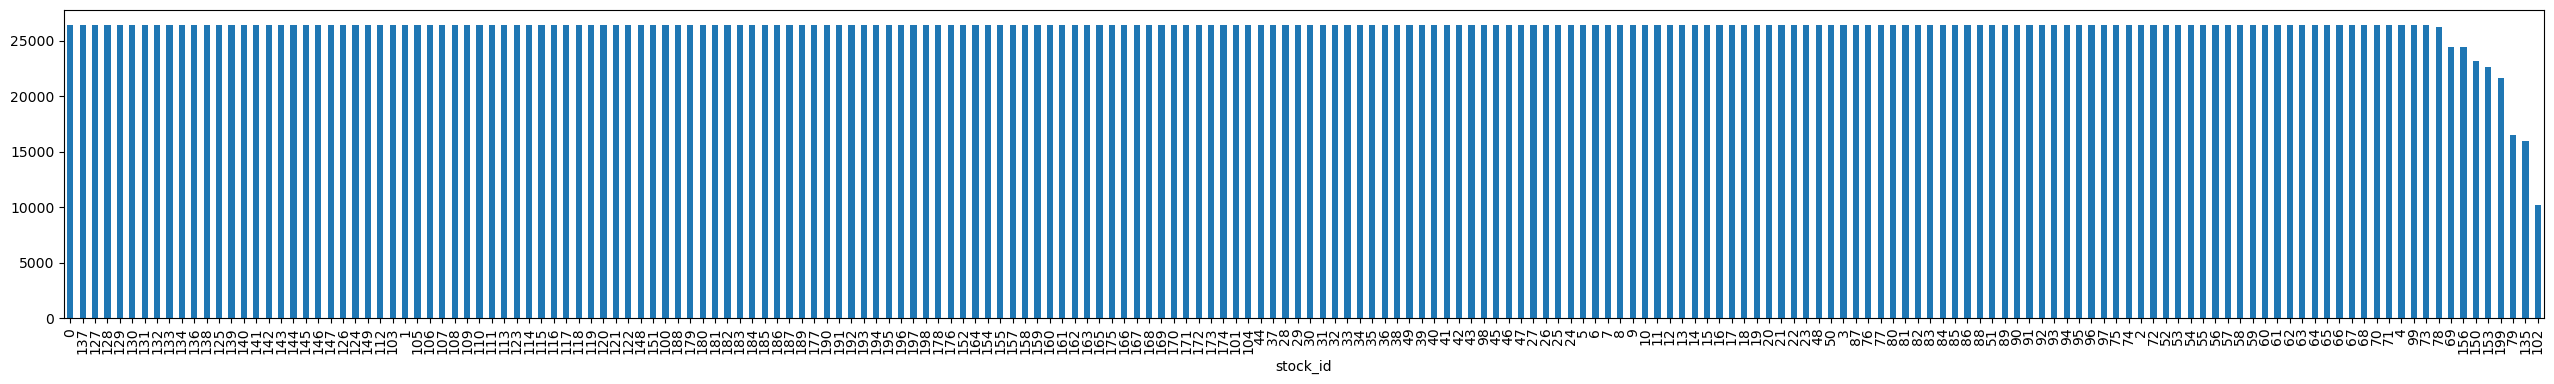

In [26]:
train_df['stock_id'].value_counts().plot.bar(figsize=(32, 4))

In [27]:
value_counts_per_date = train_df.groupby(['stock_id', 'date_id']).size().unstack(fill_value=0)
value_counts_per_date['Total'] = value_counts_per_date.sum(axis=1)
display(value_counts_per_date)
display(value_counts_per_date.query('Total!=26455'))

date_id    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  \
stock_id                                                                       
0         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
1         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
2         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
3         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
4         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
...       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
196       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
197       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
198       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  \
stock_id                                                                       
0         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
1         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
2         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
3         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
4         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
...       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
196       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
197       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
198       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  \
stock_id                                                                       
0         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
1         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
2         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
3         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
4         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
...       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
196       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
197       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
198       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  \
stock_id                                                                       
0         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
1         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
2         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
3         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
4         55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
...       ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
196       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
197       55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55 

date_id    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  \
stock_id                                                                       
69         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
73        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
78         0   0   0   0  55  55  55  55  55  55  55  55  55  55  55  55  55   
79         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
99        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
102        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
135        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
150        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
153        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
156        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  \
stock_id                                                                       
69         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
73        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
78        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
79         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
99        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
102        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
135        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
150        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
153        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
156        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  \
stock_id                                                                       
69         0   0   0  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
73        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
78        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
79         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
99        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
102        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
135        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
150        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
153        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
156        0   0   0  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
199        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

date_id   51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  \
stock_id                                                                       
69        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
73        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
78        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
79         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
99        55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
102        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
135        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
150        0   0   0   0   0   0   0   0  55  55  55  55  55  55  55  55  55   
153        0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

array([[<Axes: title={'center': 'stock_id'}>,
        <Axes: title={'center': 'date_id'}>,
        <Axes: title={'center': 'seconds_in_bucket'}>,
        <Axes: title={'center': 'imbalance_size'}>,
        <Axes: title={'center': 'imbalance_buy_sell_flag'}>,
        <Axes: title={'center': 'reference_price'}>],
       [<Axes: title={'center': 'matched_size'}>,
        <Axes: title={'center': 'far_price'}>,
        <Axes: title={'center': 'near_price'}>,
        <Axes: title={'center': 'bid_price'}>,
        <Axes: title={'center': 'bid_size'}>,
        <Axes: title={'center': 'ask_price'}>],
       [<Axes: title={'center': 'ask_size'}>,
        <Axes: title={'center': 'wap'}>,
        <Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'time_id'}>,
        <Axes: title={'center': 'diff_ask_bid_price'}>,
        <Axes: title={'center': 'sum_ask_bid_price'}>],
       [<Axes: title={'center': 'diff_ask_bid_size'}>,
        <Axes: title={'center': 'sum_ask_bid_size'}>,
    

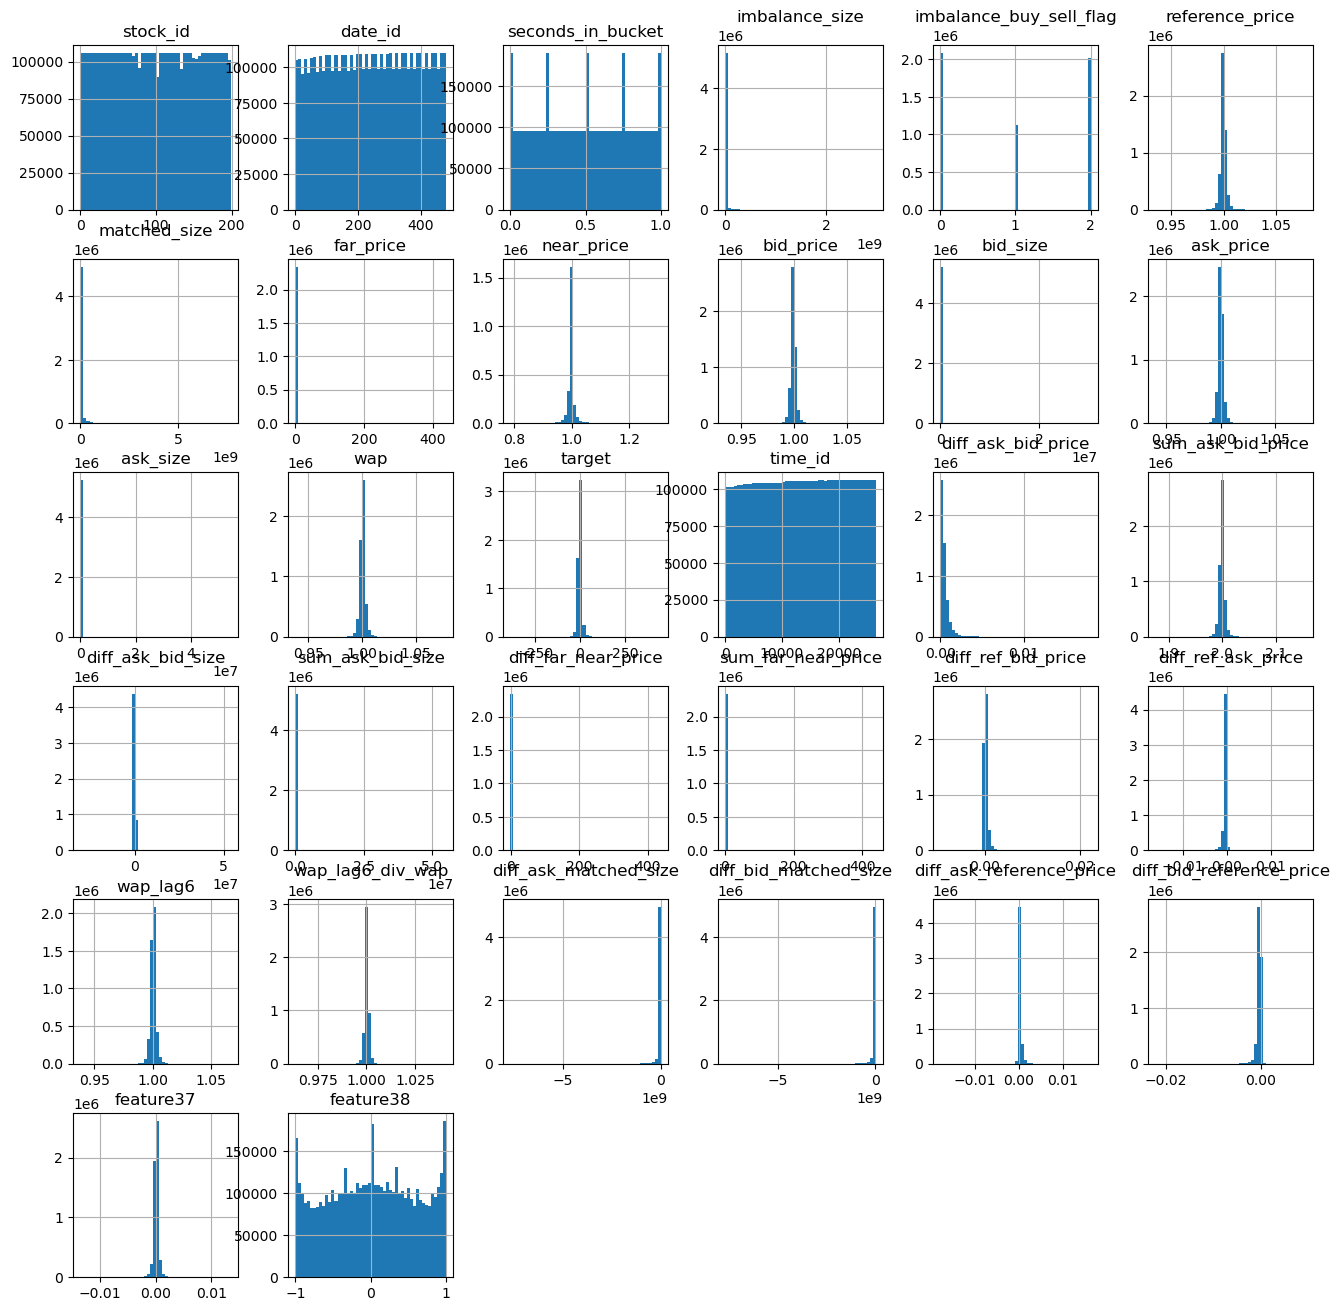

In [28]:
train_df.hist(bins=50, figsize=(16, 16))

In [29]:
display(train_df.dtypes)
display(train_df.describe())

stock_id                      int64
date_id                       int64
seconds_in_bucket           float64
imbalance_size              float64
imbalance_buy_sell_flag       int64
reference_price             float64
matched_size                float64
far_price                   float64
near_price                  float64
bid_price                   float64
bid_size                    float64
ask_price                   float64
ask_size                    float64
wap                         float64
target                      float64
time_id                       int64
row_id                       object
diff_ask_bid_price          float64
sum_ask_bid_price           float64
diff_ask_bid_size           float64
sum_ask_bid_size            float64
diff_far_near_price         float64
sum_far_near_price          float64
diff_ref_bid_price          float64
diff_ref_ask_price          float64
wap_lag6                    float64
wap_lag6_div_wap            float64
diff_ask_matched_size       

stock_id       date_id  seconds_in_bucket  imbalance_size  \
count  5.237980e+06  5.237980e+06       5.237980e+06    5.237760e+06   
mean   9.928856e+01  2.415100e+02       5.000000e-01    5.715293e+06   
std    5.787176e+01  1.385319e+02       2.939724e-01    2.051591e+07   
min    0.000000e+00  0.000000e+00       0.000000e+00    0.000000e+00   
25%    4.900000e+01  1.220000e+02       2.407407e-01    8.453415e+04   
50%    9.900000e+01  2.420000e+02       5.000000e-01    1.113604e+06   
75%    1.490000e+02  3.610000e+02       7.592593e-01    4.190951e+06   
max    1.990000e+02  4.800000e+02       1.000000e+00    2.982028e+09   

       imbalance_buy_sell_flag  reference_price  matched_size     far_price  \
count             5.237980e+06     5.237760e+06  5.237760e+06  2.343638e+06   
mean              9.881038e-01     9.999955e-01  4.510025e+07  1.001713e+00   
std               8.853374e-01     2.532497e-03  1.398413e+08  7.214705e-01   
min               0.000000e+00     9.352850e-01  4.316610e+03  7.700000e-05   
25%               0.000000e+00     9.987630e-01  5.279575e+06  9.963320e-01   
50%               1.000000e+00     9.999670e-01  1.288264e+07  9.998830e-01   
75%               2.000000e+00     1.001174e+00  3.270013e+07  1.003318e+00   
max               2.000000e+00     1.077488e+00  7.713682e+09  4.379531e+02   

         near_price     bid_price      bid_size     ask_price      ask_size  \
count  2.380800e+06  5.237760e+06  5.237980e+06  5.237760e+06  5.237980e+06   
mean   9.996601e-01  9.997263e-01  5.181359e+04  1.000264e+00  5.357568e+04   
std    1.216920e-02  2.499345e-03  1.114214e+05  2.510042e-03  1.293554e+05   
min    7.869880e-01  9.349150e-01  0.000000e+00  9.398270e-01  0.000000e+00   
25%    9.971000e-01  9.985290e-01  7.374720e+03  9.990290e-01  7.823700e+03   
50%    9.998890e-01  9.997280e-01  2.196900e+04  1.000207e+00  2.301792e+04   
75%    1.002590e+00  1.000905e+00  5.583168e+04  1.001414e+00  5.787841e+04   
max    1.309732e+00  1.077488e+00  3.028784e+07  1.077836e+00  5.440500e+07   

                wap        target       time_id  diff_ask_bid_price  \
count  5.237760e+06  5.237892e+06  5.237980e+06        5.237760e+06   
mean   9.999920e-01 -4.756125e-02  1.331005e+04        5.382061e-04   
std    2.497509e-03  9.452860e+00  7.619271e+03        5.831490e-04   
min    9.380080e-01 -3.852898e+02  0.000000e+00        3.000000e-06   
25%    9.987810e-01 -4.559755e+00  6.729000e+03        2.150000e-04   
50%    9.999970e-01 -6.020069e-02  1.334500e+04        3.690000e-04   
75%    1.001149e+00  4.409552e+00  1.990700e+04        6.560000e-04   
max    1.077675e+00  4.460704e+02  2.645400e+04        1.804300e-02   

       sum_ask_bid_price  diff_ask_bid_size  sum_ask_bid_size  \
count       5.237760e+06       5.237980e+06      5.237980e+06   
mean        1.999991e+00       1.762090e+03      1.053893e+05   
std         4.975340e-03       1.453429e+05      1.927967e+05   
min         1.874742e+00      -3.027992e+07      0.000000e+00   
25%         1.997588e+00      -1.994511e+04      2.434839e+04   
50%         1.999943e+00       1.891000e+02      5.267618e+04   
75%         2.002287e+00       2.210972e+04      1.151419e+05   
max         2.155324e+00       5.394155e+07      5.486845e+07   

       diff_far_near_price  sum_far_near_price  diff_ref_bid_price  \
count         2.343638e+06        2.343638e+06        5.237760e+06   
mean          2.078938e-03        2.001347e+00        2.692479e-04   
std           7.212226e-01        7.218599e-01        4.562050e-04   
min          -9.955370e-01        9.492450e-01       -9.411000e-03   
25%          -3.740000e-04        1.993271e+00        0.000000e+00   
50%           0.000000e+00        1.999766e+00        1.530000e-04   
75%           2.660000e-04        2.006061e+00        3.570000e-04   
max           4.369466e+02        4.389596e+02        2.220400e-02   

       diff_ref_ask_price      wap_lag6  wap_lag6_div_wap  \
count        5.23776

In [30]:
print(f'# of unique stock_id: {train_df["stock_id"].nunique()}')
print(f'# of unique date_id: {train_df["date_id"].nunique()}')

# of unique stock_id: 200
# of unique date_id: 481


In [31]:
print(train_df['time_id'].min(), train_df['time_id'].max())
display(np.arange(train_df['time_id'].min(), train_df['time_id'].max()))

0 26454


array([    0,     1,     2, ..., 26451, 26452, 26453])

In [32]:
train_df.query('stock_id==0')

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0           0.000000      3180602.69   
191             0        0           0.018519      1299772.70   
382             0        0           0.037037      1299772.70   
573             0        0           0.055556      1299772.70   
764             0        0           0.074074      1218204.43   
...           ...      ...                ...             ...   
5236980         0      480           0.925926            0.00   
5237180         0      480           0.944444            0.00   
5237380         0      480           0.962963       475513.69   
5237580         0      480           0.981481       475513.69   
5237780         0      480           1.000000       475513.69   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                              2         0.999812   13380276.64        NaN   
191                            2         1.000026   15261106.63        NaN   
382                            2         0.999919   15261106.63        NaN   
573                            2         1.000133   15261106.63        NaN   
764                            2         1.000455   15342674.90        NaN   
...                          ...              ...           ...        ...   
5236980                        1         0.999017   42161928.97   0.999017   
5237180                        1         0.998842   42161928.97   0.998842   
5237380                        0         0.999193   41686415.27   0.999017   
5237580                        0         0.999193   41686415.27   0.999017   
5237780                        0         0.999193   41686415.27   0.999017   

         near_price  bid_price   bid_size  ask_price   ask_size       wap  \
0               NaN   0.999812   60651.50   1.000026    8493.03  1.000000   
191             NaN   0.999812   13996.50   1.000026   23519.16  0.999892   
382             NaN   0.999812    4665.50   0.999919   12131.60  0.999842   
573             NaN   1.000026   55998.00   1.000133   46203.30  1.000085   
764             NaN   1.000241   14655.95   1.000455   26610.45  1.000317   
...             ...        ...        ...        ...        ...       ...   
5236980    0.999017   0.999017   53827.20   0.999193  146071.08  0.999065   
5237180    0.998842   0.998842  157865.40   0.999017  120926.08  0.998941   
5237380    0.999017   0.999193   57596.67   0.999368   46780.58  0.999289   
5237580    0.999017   0.999193  156610.53   0.999368  122677.94  0.999291   
5237780    0.999017   0.999193  110123.01   0.999368  283817.38  0.999242   

           target  time_id     row_id  diff_ask_bid_price  sum_ask_bid_price  \
0       -3.029704        0      0_0_0            0.000214           1.999838   
191      0.389814        1     0_10_0            0.000214           1.999838   
382      4.220009        2     0_20_0            0.000107           1.999731   
573      5.450249        3     0_30_0            0.000107           2.000159   
764      3.169775        4     0_40_0            0.000214           2.000696   
...           ...      ...        ...                 ...                ...   
5236980  3.999472    26450  480_500_0            0.000176           1.998210   
5237180  3.190041    26451  480_510_0            0.000175           1.997859   
5237380 -0.169873    26452  480_520_0            0.000175           1.998561   
5237580  3.110170    26453  480_530_0            0.000175           1.998561   
5237780  0.760555    26454  480_540_0            0.000175           1.998561   

         diff_ask_bid_size  sum_ask_bid_size  diff_far_near_price  \
0                -52158.47          69144.53                  NaN   
191                9522.66          37515.66                  NaN   
382                7466.10          16797.10                  NaN   
573               -9794.70         102201.30                  NaN   
764               11954.50          41266.40                

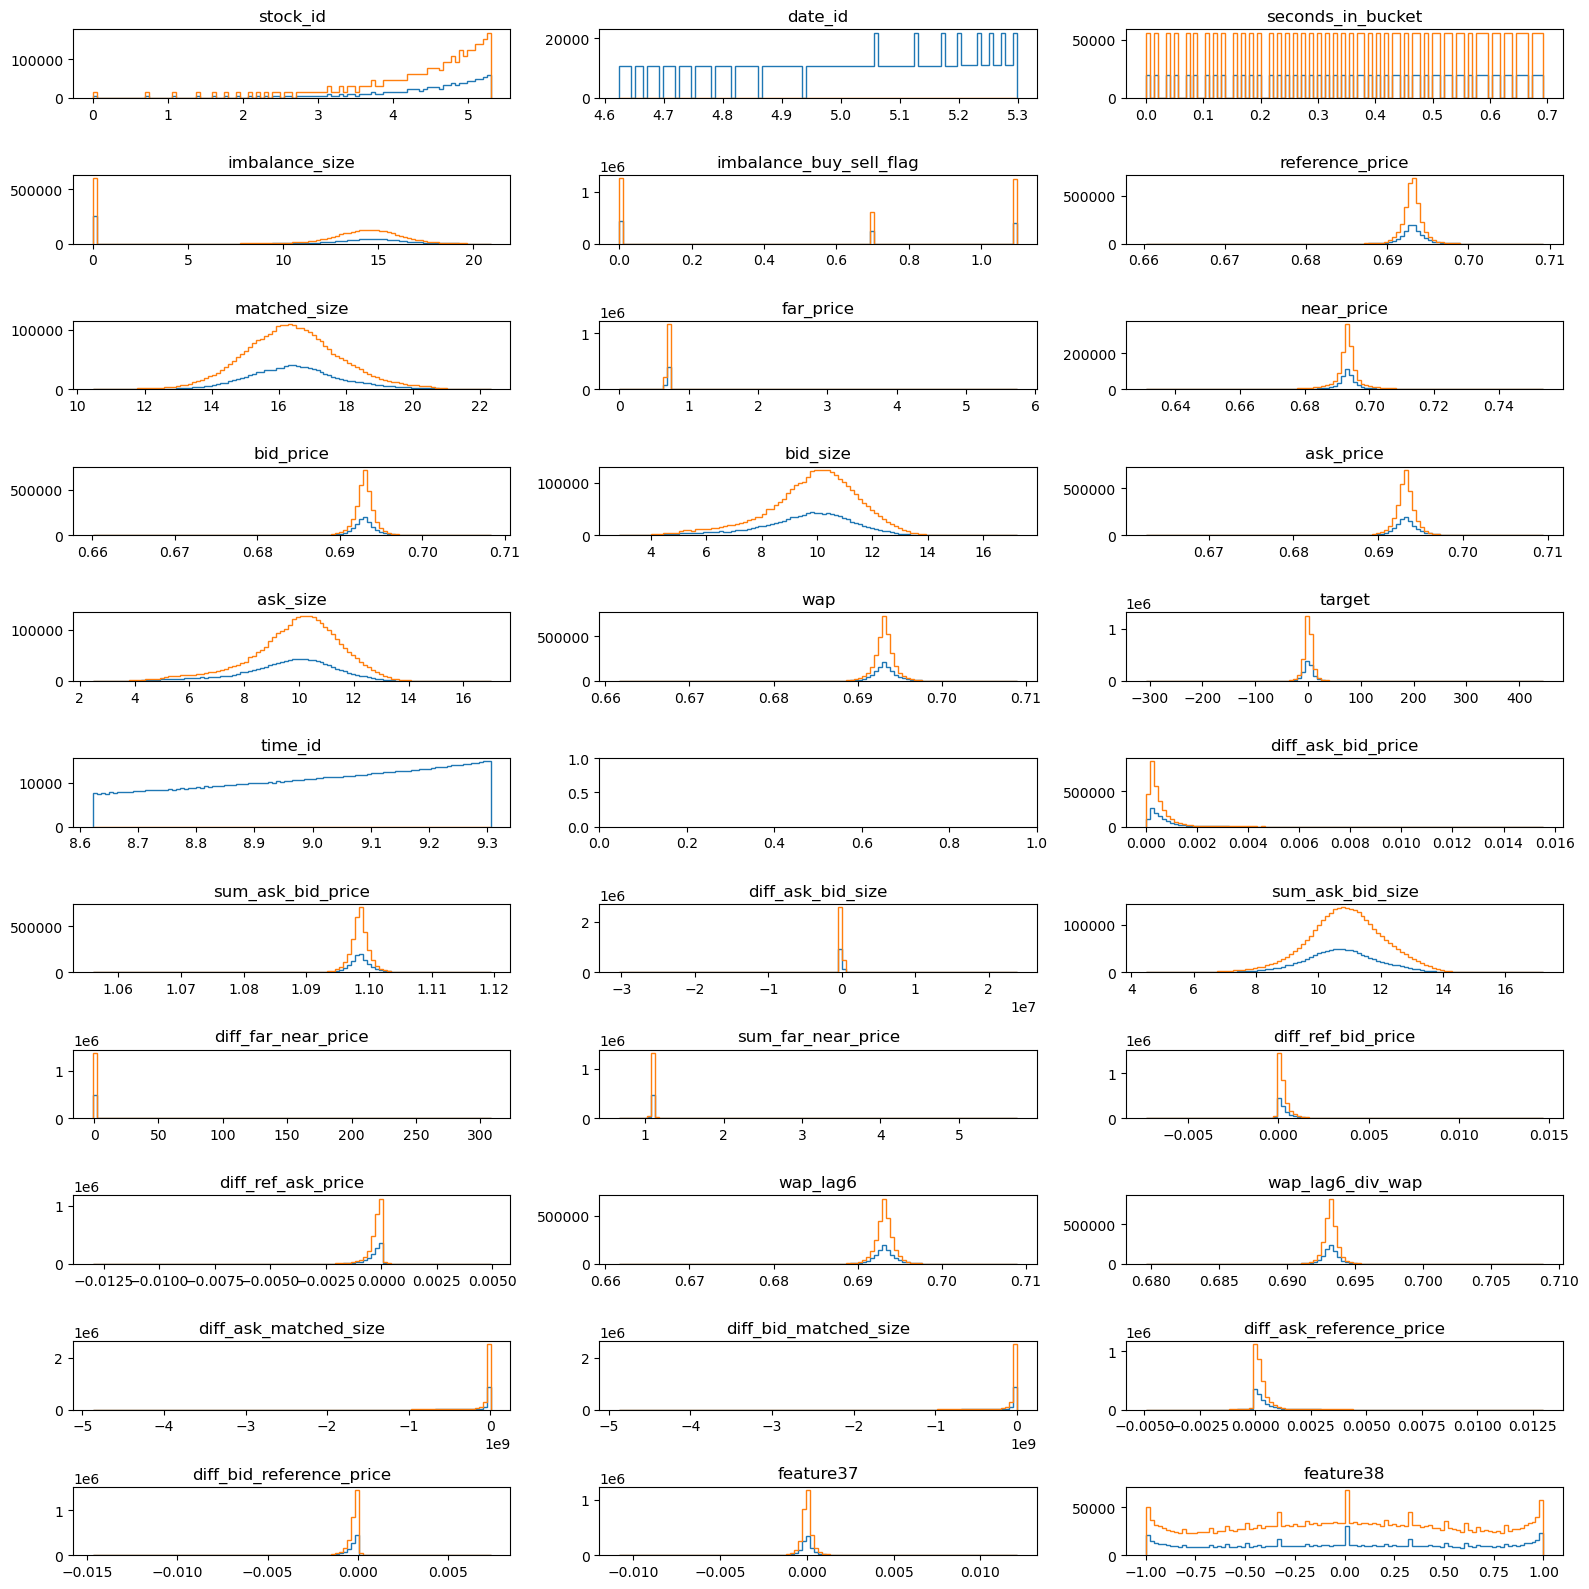

In [33]:
nrows = len(train_df.columns) // 3 if len(train_df.columns) % 3 == 0 else len(train_df.columns) // 3 + 1
_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i, col in enumerate(train_df.columns):
    if col != 'row_id':
        if train_df[col].min() < 0:
            _, bins, _ = axs[i//3, i%3].hist(train_df.query('100 < date_id < 200')[col], bins=100, histtype='step')
            axs[i//3, i%3].hist(train_df.query('date_id >= 200')[col], bins=bins, histtype='step')
        else:
            _, bins, _ = axs[i//3, i%3].hist(np.log1p(train_df.query('100 < date_id < 200')[col]), bins=100, histtype='step')
            axs[i//3, i%3].hist(np.log1p(train_df.query('date_id >= 200')[col]), bins=bins, histtype='step')
        axs[i//3, i%3].set_title(col)
plt.tight_layout()

In [34]:
display(train_df['diff_ask_reference_price'].max())
display(train_df['diff_bid_reference_price'].max())

0.01620200000000005

0.009411000000000058

In [35]:
a = (
    train_df
    .query('diff_ask_matched_size >= 0 | diff_bid_matched_size >= 0')
    [['date_id', 'seconds_in_bucket', 'stock_id', 'diff_ask_matched_size', 'diff_bid_matched_size', 'ask_size', 'bid_size', 'matched_size', 'imbalance_size']]
)
display(a)
display(pd.pivot_table(data=a, index=['date_id', 'seconds_in_bucket'], columns=['stock_id'], values=['ask_size'], aggfunc='count'))

date_id  seconds_in_bucket  stock_id  diff_ask_matched_size  \
668            0           0.055556        98              199424.32   
859            0           0.074074        98              172964.32   
1050           0           0.092593        98              175904.32   
2196           0           0.203704        98              128703.31   
2387           0           0.222222        98              140874.91   
...          ...                ...       ...                    ...   
5237123      480           0.925926       143              161582.03   
5237323      480           0.944444       143              161880.51   
5237523      480           0.962963       143              189658.83   
5237723      480           0.981481       143              187974.55   
5237923      480           1.000000       143              225223.98   

         diff_bid_matched_size    ask_size   bid_size  matched_size  \
668                 -902739.29  1191052.80   88889.19     991628.48   
859                 -870362.53  1164592.80  121265.95     991628.48   
1050                -888357.78  1167532.80  103270.70     991628.48   
2196                -916636.59  1122168.60   76828.70     993465.29   
2387                -937378.87  1134340.20   56086.42     993465.29   
...                        ...         ...        ...           ...   
5237123              434558.42   288658.04  561634.43     127076.01   
5237323              334150.42   288956.52  461226.43     127076.01   
5237523              340181.42   316734.84  467257.43     127076.01   
5237723              414020.42   315050.56  541096.43     127076.01   
5237923              414745.98   356560.60  546082.60     131336.62   

         imbalance_size  
668            19955.12  
859            19955.12  
1050           19955.12  
2196           18118.31  
2387           18118.31  
...                 ...  
5237123        21699.62  
5237323        21699.62  
5237523        21699.62  
5237723        21699.62  
5237923        17439.01  

[10100 rows x 9 columns]

ask_size                                           \
stock_id                       5   11  27  31  69  70  78  82  86  92   98    
date_id seconds_in_bucket                                                     
0       0.055556               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0   
        0.074074               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0   
        0.092593               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0   
        0.203704               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0   
        0.222222               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  1.0   
...                            ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
480     0.925926               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN   
        0.944444               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN   
        0.962963               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN   
        0.981481               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN   
        1.000000               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN   

                                                                            
stock_id                  100 101 111 117 129 135 138  143 153 155 172 194  
date_id seconds_in_bucket                                                   
0       0.055556          NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  
        0.074074          NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  
        0.092593          NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  
        0.203704          NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  
        0.222222          NaN NaN NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  
...                        ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  
480     0.925926          NaN NaN NaN NaN NaN NaN NaN  1.0 NaN NaN NaN NaN  
        0.944444          NaN NaN NaN NaN NaN NaN NaN  1.0 NaN NaN NaN NaN  
        0.962963          NaN NaN NaN NaN NaN NaN NaN  1.0 NaN NaN NaN NaN  
        0.981481          NaN NaN NaN NaN NaN NaN NaN  1.0 NaN NaN NaN NaN  
        1.000000          NaN NaN NaN NaN NaN NaN NaN  1.0 NaN NaN NaN NaN  

[8803 rows x 23 columns]

In [36]:
stock_id = 0
plot_df = train_df.query('stock_id==@stock_id & 360 <= date_id').sort_values(by='time_id')

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['target'],
        name='target', mode='lines+markers', marker={'size': 5},
    ),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['bid_price'],
        name='bid price', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['ask_price'],
        name='ask price', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['wap'],
        name='wap', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['reference_price'],
        name='reference_price', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['seconds_in_bucket'],
        name='seconds_in_bucket', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['far_price'],
        name='far_price', mode='lines+markers', marker={'size': 5},
    )
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['near_price'],
        name='near_price', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['ask_size'],
        name='ask_size', mode='lines+markers', marker={'size': 5},
    )
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['bid_size'],
        name='bid_size', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['matched_size'],
        name='matched_size', mode='lines+markers', marker={'size': 5},
    )
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['imbalance_size'],
        name='imbalance_size', mode='lines+markers', marker={'size': 5},
    )
)
fig.add_trace(
    go.Scatter(
        x=plot_df['time_id'], y=plot_df['imbalance_buy_sell_flag'],
        name='imbalance_buy_sell_flag', mode='lines+markers', marker={'size': 5}
    ),
    secondary_y=True
)
fig.show()

In [37]:
agg_features = [
    'imbalance_size',
    'matched_size',
    'reference_price',
    'far_price',
    'near_price',
    'bid_size',
    'bid_price',
    'ask_size',
    'ask_price',
    'wap',
]

statistics_per_stock = train_df.groupby('stock_id')[agg_features].agg(['mean', 'std'])
statistics_per_stock.columns = ['_'.join(col) for col in statistics_per_stock.columns]
display(statistics_per_stock)
display(statistics_per_stock.isna().sum())

imbalance_size_mean  imbalance_size_std  matched_size_mean  \
stock_id                                                               
0                4.210671e+06        8.321268e+06       2.575498e+07   
1                5.185133e+05        9.908059e+05       4.222393e+06   
2                1.866116e+06        1.612834e+07       9.895372e+06   
3                9.331595e+06        1.334086e+07       6.995952e+07   
4                3.809995e+06        5.641951e+06       2.732611e+07   
...                       ...                 ...                ...   
195              4.244478e+06        6.273613e+06       2.894484e+07   
196              1.188229e+06        2.198913e+06       6.720051e+06   
197              2.652288e+06        6.381218e+06       1.374177e+07   
198              1.288791e+07        1.721219e+07       1.008507e+08   
199              3.158094e+06        1.078062e+07       2.435742e+07   

          matched_size_std  reference_price_mean  reference_price_std  \
stock_id                                                                
0             2.104866e+07              0.999835             0.001679   
1             1.269290e+07              0.999926             0.002845   
2             5.605824e+07              1.000149             0.002714   
3             5.006637e+07              0.999978             0.001451   
4             2.279876e+07              0.999859             0.001869   
...                    ...                   ...                  ...   
195           2.241942e+07              0.999915             0.001528   
196           6.394378e+06              1.000072             0.001727   
197           1.842076e+07              1.000051             0.002361   
198           7.636303e+07              0.999871             0.001579   
199           4.351652e+07              1.000093             0.002186   

          far_price_mean  far_price_std  near_price_mean  near_price_std  \
stock_id                                                                   
0               0.996826       0.017129         0.997337        0.013321   
1               0.999121       0.019317         0.999929        0.010931   
2               1.001351       0.021503         1.000296        0.010853   
3               0.998877       0.013401         0.999056        0.010039   
4               0.998720       0.025369         0.999115        0.010009   
...                  ...            ...              ...             ...   
195             0.997547       0.017663         0.998263        0.011793   
196             0.998950       0.017290         0.998953        0.013986   
197             0.999987       0.018836         0.999984        0.012686   
198             0.999026       0.010320         0.999265        0.009116   
199             0.998819       0.015820         0.999599        0.013319   

          bid_size_mean   bid_size_std  bid_price_mean  bid_price_std  \
stock_id                                                                
0          36045.936745   75318.385672        0.999735       0.001675   
1          22565.737446   33339.741669        0.999480       0.002795   
2          23600.347570   35444.210110        0.999697       0.002670   
3          32339.317300   45832.987823        0.999872       0.001450   
4          28348.285391   42141.152589        0.999728       0.001856   
...                 ...            ...             ...            ...   
195        38422.849204   47541.936232        0.999840       0.001525   
196        31895.931039   36408.928150        0.999917       0.001709   
197        25257.370363   35573.943866        0.999879       0.002349   
198       202829.584280  175991.694861        0.999756       0.001574   
199        81383.169042  107257.478734        0.999918       0.002162   

          ask_size_mean   ask_size_std  ask_price_mean  ask_price_std  \
stock_id                                                                
0          38356.347457   57668.534358

imbalance_size_mean     0
imbalance_size_std      0
matched_size_mean       0
matched_size_std        0
reference_price_mean    0
reference_price_std     0
far_price_mean          0
far_price_std           0
near_price_mean         0
near_price_std          0
bid_size_mean           0
bid_size_std            0
bid_price_mean          0
bid_price_std           0
ask_size_mean           0
ask_size_std            0
ask_price_mean          0
ask_price_std           0
wap_mean                0
wap_std                 0
dtype: int64

In [38]:
standardized_statistics_per_stock = StandardScaler().fit_transform(statistics_per_stock)

kmeans = KMeans(n_clusters=10)
statistics_per_stock['cluster'] = kmeans.fit_predict(standardized_statistics_per_stock)

display(statistics_per_stock)
display(statistics_per_stock['cluster'].value_counts())

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



imbalance_size_mean  imbalance_size_std  matched_size_mean  \
stock_id                                                               
0                4.210671e+06        8.321268e+06       2.575498e+07   
1                5.185133e+05        9.908059e+05       4.222393e+06   
2                1.866116e+06        1.612834e+07       9.895372e+06   
3                9.331595e+06        1.334086e+07       6.995952e+07   
4                3.809995e+06        5.641951e+06       2.732611e+07   
...                       ...                 ...                ...   
195              4.244478e+06        6.273613e+06       2.894484e+07   
196              1.188229e+06        2.198913e+06       6.720051e+06   
197              2.652288e+06        6.381218e+06       1.374177e+07   
198              1.288791e+07        1.721219e+07       1.008507e+08   
199              3.158094e+06        1.078062e+07       2.435742e+07   

          matched_size_std  reference_price_mean  reference_price_std  \
stock_id                                                                
0             2.104866e+07              0.999835             0.001679   
1             1.269290e+07              0.999926             0.002845   
2             5.605824e+07              1.000149             0.002714   
3             5.006637e+07              0.999978             0.001451   
4             2.279876e+07              0.999859             0.001869   
...                    ...                   ...                  ...   
195           2.241942e+07              0.999915             0.001528   
196           6.394378e+06              1.000072             0.001727   
197           1.842076e+07              1.000051             0.002361   
198           7.636303e+07              0.999871             0.001579   
199           4.351652e+07              1.000093             0.002186   

          far_price_mean  far_price_std  near_price_mean  near_price_std  \
stock_id                                                                   
0               0.996826       0.017129         0.997337        0.013321   
1               0.999121       0.019317         0.999929        0.010931   
2               1.001351       0.021503         1.000296        0.010853   
3               0.998877       0.013401         0.999056        0.010039   
4               0.998720       0.025369         0.999115        0.010009   
...                  ...            ...              ...             ...   
195             0.997547       0.017663         0.998263        0.011793   
196             0.998950       0.017290         0.998953        0.013986   
197             0.999987       0.018836         0.999984        0.012686   
198             0.999026       0.010320         0.999265        0.009116   
199             0.998819       0.015820         0.999599        0.013319   

          bid_size_mean   bid_size_std  bid_price_mean  bid_price_std  \
stock_id                                                                
0          36045.936745   75318.385672        0.999735       0.001675   
1          22565.737446   33339.741669        0.999480       0.002795   
2          23600.347570   35444.210110        0.999697       0.002670   
3          32339.317300   45832.987823        0.999872       0.001450   
4          28348.285391   42141.152589        0.999728       0.001856   
...                 ...            ...             ...            ...   
195        38422.849204   47541.936232        0.999840       0.001525   
196        31895.931039   36408.928150        0.999917       0.001709   
197        25257.370363   35573.943866        0.999879       0.002349   
198       202829.584280  175991.694861        0.999756       0.001574   
199        81383.169042  107257.478734        0.999918       0.002162   

          ask_size_mean   ask_size_std  ask_price_mean  ask_price_std  \
stock_id                                                                
0          38356.347457   57668.534358

cluster
6    62
1    57
8    37
4    14
0    13
2    10
9     3
3     2
5     1
7     1
Name: count, dtype: int64

In [42]:
cluster_dict = {}
for cluster in range(10):
    cluster_dict[cluster] = statistics_per_stock.query('cluster==@cluster').index.to_list()
print(cluster_dict)

{0: [12, 38, 84, 88, 95, 126, 140, 142, 150, 160, 163, 175, 179], 1: [6, 7, 13, 14, 15, 16, 17, 19, 27, 28, 43, 46, 47, 50, 54, 57, 58, 60, 64, 71, 74, 75, 81, 91, 96, 99, 103, 106, 113, 115, 119, 124, 125, 128, 131, 141, 145, 146, 154, 155, 157, 159, 169, 173, 176, 178, 182, 183, 184, 185, 190, 192, 193, 194, 196, 197, 199], 2: [11, 70, 82, 86, 92, 100, 129, 156, 174, 180], 3: [45, 112], 4: [8, 26, 69, 83, 98, 109, 117, 121, 134, 143, 151, 165, 166, 198], 5: [31], 6: [0, 3, 4, 9, 10, 20, 21, 23, 24, 25, 29, 30, 32, 34, 35, 36, 37, 39, 44, 48, 49, 52, 53, 55, 63, 65, 66, 68, 72, 73, 76, 77, 90, 97, 104, 105, 110, 114, 116, 120, 123, 130, 132, 133, 136, 137, 139, 144, 147, 148, 149, 152, 153, 164, 167, 170, 171, 181, 186, 187, 189, 195], 7: [122], 8: [1, 2, 5, 18, 22, 33, 40, 42, 51, 56, 59, 61, 62, 67, 78, 79, 80, 85, 87, 89, 93, 94, 101, 102, 107, 108, 111, 118, 127, 135, 138, 158, 161, 162, 172, 177, 188], 9: [41, 168, 191]}
